# Bayesian vector autorergession models
The [vector autorergession (VAR) model](https://en.wikipedia.org/wiki/Vector_autoregression) is used to model relationships between multiple time series of interest, making it one of the most commonly used models in empirical macroeconomics. When the VAR is estimated using Bayesian methods, it's often referred to as a [*Bayesian VAR*](https://en.wikipedia.org/wiki/Bayesian_vector_autoregression) or *BVAR* for short.

In [1]:
# Load packages
using Distributions
using Plots
using LinearAlgebra
using Printf
using SpecialFunctions
using SparseArrays


## Model
As the name suggests, the *vector* autogressive model, is a multivariate generalization of the autoregressive (AR) model. If there are n AR 
 
The n-variable vector autorergession model of order $p$, denoted VAR(p), is defined as
$$
\mathbf{y}_t = \mathbf{b} + \mathbf{B}_{1}\mathbf{y}_{t-1} + \dots + \mathbf{B}_{p}\mathbf{y}_{t-p} + \boldsymbol{\varepsilon}_t
$$
where $\mathbf{y}_t=[y_{1,t},\dots,y_{n,t}]',\mathbf{b}=[b_1,\dots,b_n]',\boldsymbol{\varepsilon}_t=[\varepsilon_{1,t},\dots,\varepsilon_{1,t}]'$ are $n\times 1$ vectors and $\mathbf{B}_i$, $i=1,\dots,p$ are $n\times n$ matrices of autoregressive coefficients. Each equation has $k=np+1$ regressors and the total system has $nk=n(np+1)$ coefficients. 


**Example**: A 2-variable VAR(1) model has the following representation
$$
\underset{\mathbf{y}_t}{\underbrace{\begin{bmatrix}
y_{1,t}\\
y_{2,t}
\end{bmatrix}}}
=
\underset{\mathbf{b}}{\underbrace{\begin{bmatrix}
b_{1}\\
b_{2}
\end{bmatrix}}}
+ 
\underset{\mathbf{B}}{\underbrace{\begin{bmatrix}
B_{1,1} & B_{1,2}\\
B_{2,1} & B_{2,2}\\
\end{bmatrix}}}
\underset{\mathbf{y}_{t-1}}{\underbrace{\begin{bmatrix}
y_{1,t-1}\\
y_{2,t-1}
\end{bmatrix}}}
+
\underset{\boldsymbol{\varepsilon}_t}{\underbrace{\begin{bmatrix}
\varepsilon_{1,t}\\
\varepsilon_{2,t}
\end{bmatrix}}}
$$


In this lecture we will assume that the error term are independent and identically distributed (iid) according to
$$
\boldsymbol{\varepsilon}_t\sim {N}(\mathbf{0},\boldsymbol{\Sigma})
$$
in which the covariance matrix $\boldsymbol{\Sigma}$ is a full $n\times n$ matrix.

**Remarks**:
1. **Reduced form VAR**: This representation of the VAR model is referred to as the [*reduced form VAR*](https://en.wikipedia.org/wiki/Vector_autoregression#Structural_vs._reduced_form) because it assumes that the time series are *contemporaneously independent*, i.e. independent at date t. 
2. **Structural VAR**: The [*structural VAR*](https://en.wikipedia.org/wiki/Vector_autoregression#Structural_vs._reduced_form) model allows for the time series to be *contemporaneously dependent*, however estimation is more involved and requires a more in depth knowledge of time series econometrics. See, e.g. [Baumeister and Hamilton (2015)](https://onlinelibrary.wiley.com/doi/abs/10.3982/ECTA12356). 

## Link to linear regression
The VAR model can be written as a multivariate normal linear regression model
$$
\mathbf{y}_t = \mathbf{x}_t\boldsymbol{\beta} + \boldsymbol{\varepsilon}_t, \quad \boldsymbol{\varepsilon}_t\sim {N}(\mathbf{0},\boldsymbol{\Sigma})
$$
where $\mathbf{x}_t = \mathbf{I}_n\otimes\left[1,\mathbf{y}'_{t-1},\dots,\mathbf{y}'_{t-p}\right]$ is $n\times nk$, and $\boldsymbol{\beta} = \text{vec}(\left[\mathbf{b},\boldsymbol{\beta}_1,\dots,\boldsymbol{\beta}_p\right]')$ is $nk\times1$. The operator $\otimes$ is the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) and $\text{vec}(\mathbf{A})$ is the [vectorization operator](https://en.wikipedia.org/wiki/Vectorization_%28mathematics%29) which stacks the rows of the VAR coefficients in each equation into a $nk\times1$ column vector.

**Example**: A 2-variable VAR(1) model has the following representation
$$
\underset{\mathbf{y}_t}{\underbrace{\begin{bmatrix}
y_{1,t}\\
y_{2,t}
\end{bmatrix}}}
=
\underset{\mathbf{x}_{t-1}}{\underbrace{\begin{bmatrix}
1 & y_{1,t-1} & y_{2,t-1} & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & y_{1,t-1} & y_{2,t-1} \\
\end{bmatrix}}}
\underset{\boldsymbol{\beta}}{\underbrace{\begin{bmatrix}
b_{1}\\
B_{1,1}\\
B_{1,2}\\
b_{2}\\
B_{2,1}\\
B_{2,2}\\
\end{bmatrix}}}
+
\underset{\boldsymbol{\varepsilon}_t}{\underbrace{\begin{bmatrix}
\varepsilon_{1,t}\\
\varepsilon_{2,t}
\end{bmatrix}}}
$$


## Estimation
For estimation purposes it's convenient to stack the model over all dates, $t=1,\dots,T$ as follows
$$
\mathbf{y} = \mathbf{X}\boldsymbol{\beta} + \boldsymbol{\varepsilon}, \quad \boldsymbol{\varepsilon}\sim {N}(\mathbf{0},\mathbf{I}_T\otimes\boldsymbol{\Sigma})
$$
where $\mathbf{y} = [y_1,\dots,y_T]'$ and $\boldsymbol{\varepsilon} = [\varepsilon_1,\dots,\varepsilon_T]'$ are $Tn\times1$,  and 
$\mathbf{X}$ is a $Tn\times nk$ matrix that stacks the regressors into a matrix
$$
\mathbf{X}=\begin{bmatrix}
\mathbf{x}_1 \\ 
\vdots \\ 
\mathbf{x}_T 
\end{bmatrix}
$$

The probability model representation of the VAR model is given by
$$
\mathbf{y} \sim N\left(\mathbf{X}\boldsymbol{\beta},\mathbf{I}_T\otimes\boldsymbol{\Sigma}\right)
$$
Estimating the VAR model is therefore the same as estimating the parameters of a multivariate Normal distribution with unknown mean and covariance.

To estimate the model parameters $\boldsymbol{\beta}$ and $\boldsymbol{\Sigma}$ with Bayesian methods we apply Bayes rule
$$
\begin{align}
p(\boldsymbol{\beta},\boldsymbol{\Sigma}|\mathbf{y}) &= \frac{p(\mathbf{y}|\boldsymbol{\beta},\boldsymbol{\Sigma})p(\boldsymbol{\beta},\boldsymbol{\Sigma})}{p(\mathbf{y})}\\
&\propto p(\mathbf{y}|\boldsymbol{\beta},\boldsymbol{\Sigma})p(\boldsymbol{\beta},\boldsymbol{\Sigma})\\
\end{align}
$$
in which $p(\mathbf{y}|\boldsymbol{\beta},\boldsymbol{\Sigma})$ is the likelihood function and $p(\boldsymbol{\beta},\boldsymbol{\Sigma})$ is the (joint) prior distribution. We now consider each in turn.


### Likelihood
There are two useful representations of the likelihood. 

First, when deriving posterior for $\boldsymbol{\beta}$ we will use the fact that
$$
\mathbf{y}|\boldsymbol{\beta},\boldsymbol{\Sigma} \sim {N}\left(\mathbf{X}\boldsymbol{\beta},\mathbf{I}_T\otimes\boldsymbol{\Sigma}\right),\label{eq:likelihood}
$$
to get
$$
\begin{align*}
f(\mathbf{y}|\boldsymbol{\beta},\boldsymbol{\Sigma})  &=  (2\pi)^{-\frac{Tn}{2}}\left|\mathbf{I}_T\otimes\boldsymbol{\Sigma}\right|^{-\frac{1}{2}}\exp\left(-\frac{1}{2}(\mathbf{y}-\mathbf{X}\boldsymbol{\beta})'(\mathbf{I}_T\otimes\boldsymbol{\Sigma})^{-1}(\mathbf{y}-\mathbf{X}\boldsymbol{\beta})\right),\\
&= (2\pi)^{-\frac{Tn}{2}}\left|\boldsymbol{\Sigma}\right|^{-\frac{T}{2}}\exp\left(-\frac{1}{2}(\mathbf{y}-\mathbf{X}\boldsymbol{\beta})'(\mathbf{I}_T\otimes\boldsymbol{\Sigma}^{-1})(\mathbf{y}-\mathbf{X}\boldsymbol{\beta})\right),
\end{align*}
$$
where the second equality holds because $\left|\mathbf{I}_T\otimes\boldsymbol{\Sigma}\right|=\left|\mathbf{I}_T\right|^n\left|\boldsymbol{\Sigma}\right|^T=\left|\boldsymbol{\Sigma}\right|^T$ and $(\mathbf{I}_T\otimes\boldsymbol{\Sigma})^{-1}=(\mathbf{I}_T^{-1}\otimes\boldsymbol{\Sigma}^{-1})=(\mathbf{I}_T\otimes\boldsymbol{\Sigma}^{-1})$.

Second, when deriving posterior for $\boldsymbol{\Sigma}$ we will use the fact that
$$
\mathbf{y}_t|\boldsymbol{\beta},\boldsymbol{\Sigma} \sim {N}\left(\mathbf{X}_t\boldsymbol{\beta},\boldsymbol{\Sigma}\right)
$$
to get
$$
\begin{align*}
f(\mathbf{y}|\boldsymbol{\beta},\sigma^2)  &= \prod_{t=1}^{T}f(\mathbf{y}_t|\boldsymbol{\beta},\sigma^2),\\ 
&= (2\pi)^{-\frac{Tn}{2}}\left|\boldsymbol{\Sigma}\right|^{-\frac{T}{2}}\exp\left(-\frac{1}{2}\sum_{t=1}^{T}(\mathbf{y}_t-\mathbf{X}_t\boldsymbol{\beta})'\boldsymbol{\Sigma}^{-1}(\mathbf{y}_t-\mathbf{X}_t\boldsymbol{\beta})\right).
\end{align*}
$$

### Priors
Assuming prior independence implies that
$$
p(\boldsymbol{\beta},\boldsymbol{\Sigma})=p(\boldsymbol{\beta})p(\boldsymbol{\Sigma}).
$$
As in the linear regression model, we assume a multivariate Normal prior for the VAR coefficients
$$
\boldsymbol{\beta} \sim {N}(\boldsymbol{\beta}_0,\mathbf{V}_{\boldsymbol{\beta}})
$$
Since the inverse-Gamma distribution is a univariate distribution, it can no longer be applied to the case of a general covariance matrix $\boldsymbol{\Sigma}$. Instead, we assume an [inverse-Wishart](https://en.wikipedia.org/wiki/Inverse-Wishart_distribution#:~:text=In%20statistics%2C%20the%20inverse%20Wishart%20distribution%2C%20also%20called,the%20covariance%20matrix%20of%20a%20multivariate%20normal%20distribution.) prior
$$
\boldsymbol{\Sigma} \sim {IW}(\nu_0,\mathbf{S}_0)
$$

**Remarks**:
1. **inverse-Wishart and inverse-Gamma**: The inverse-Wishart distribution is the multivariate generalization of the inverse-gamma distribution ([Proof](https://en.wikipedia.org/wiki/Inverse-Wishart_distribution#Related_distributions)).
2. **Conjugacy**: The independent Normal and inverse-Wishart priors are conjugate priors for the multivariate Normal likelihood function. This facilitates the use of a 2 block Gibbs Sampler which we discuss in the next section.

### Posterior
We use a 2 block Gibbs sampler with full conditional distributions
1. $p(\mathbf{\boldsymbol{\beta}|\mathbf{y},\boldsymbol{\Sigma}})$
2. $p(\mathbf{\boldsymbol{\Sigma}|\mathbf{y},\boldsymbol{\beta}})$

#### Step 1: Sample $\boldsymbol{\beta}$

$$
\begin{align}
p\left(\boldsymbol{\beta}|\mathbf{y},\boldsymbol{\Sigma}\right) &\propto f\left(\mathbf{y}|\boldsymbol{\beta},\boldsymbol{\Sigma}\right)p\left(\boldsymbol{\beta}\right)\\
&\propto\exp\left(-\frac{1}{2}\left(\mathbf{y}-\mathbf{X}\boldsymbol{\beta}\right)'(\mathbf{I}_n\otimes\boldsymbol{\Sigma}^{-1})\left(\mathbf{y}-\mathbf{X}\boldsymbol{\beta}\right)\right)\exp\left(-\frac{1}{2}\left(\boldsymbol{\beta}-\boldsymbol{\beta}_0\right)'\mathbf{V}_{\boldsymbol{\beta}}^{-1}\left(\boldsymbol{\beta}-\boldsymbol{\beta}_0\right)\right)\\
&\propto\exp\left(-\frac{1}{2}\left(\boldsymbol{\beta}'\mathbf{X}'(\mathbf{I}_n\otimes\boldsymbol{\Sigma}^{-1})\mathbf{X}\boldsymbol{\beta}-2\boldsymbol{\beta}'\mathbf{X}'\mathbf{y}\right)\right)\left(-\frac{1}{2}\left(\boldsymbol{\beta}'\mathbf{V}_{\boldsymbol{\beta}}^{-1}\boldsymbol{\beta}-2\boldsymbol{\beta}'\mathbf{V}_{\boldsymbol{\beta}}^{-1}\boldsymbol{\beta}_0\right)\right)\\
&\propto\exp\left(-\frac{1}{2}\left(\boldsymbol{\beta}'\left(\mathbf{X}'(\mathbf{I}_n\otimes\boldsymbol{\Sigma}^{-1})\mathbf{X}+\mathbf{V}_{\boldsymbol{\beta}}^{-1}\right)\boldsymbol{\beta}-2\boldsymbol{\beta}\left(\mathbf{X}'(\mathbf{I}_n\otimes\boldsymbol{\Sigma}^{-1})\mathbf{y}+\mathbf{V}_{\boldsymbol{\beta}}^{-1}\boldsymbol{\beta}_0\right)\right)\right)
\end{align}
$$
The final line is the kernel of a multivariate normal density which implies that
$$
\begin{align} 
(\boldsymbol{\beta}|\mathbf{y},\boldsymbol{\Sigma}) \sim {N}\left(\hat{\boldsymbol{\beta}},\mathbf{D}_{\boldsymbol{\beta}}^{-1}\right)
\end{align}
$$
with 
$$
\hat{\boldsymbol{\beta}} = \mathbf{D}_{\boldsymbol{\beta}}^{-1}\left(\mathbf{X}'(\mathbf{I}_T\otimes\boldsymbol{\Sigma}^{-1})\mathbf{y} + \mathbf{V}^{-1}_{\boldsymbol{\beta}}\boldsymbol{\beta}_0\right), \quad \mathbf{D}_{\boldsymbol{\beta}}^{-1} = \mathbf{X}'(\mathbf{I}_T\otimes\boldsymbol{\Sigma}^{-1})\mathbf{X} + \mathbf{V}^{-1}_{\boldsymbol{\beta}}
$$

**Remarks**:
1. **Precision sampler**: We use the *precision matrix* $\mathbf{D}_{\boldsymbol{\beta}}^{-1}$ as the covariance of the multivariate normal distribution to facilitate the use of the *precision sampler* which we discuss in the section on computational points.

#### Step 2: Sample $\boldsymbol{\Sigma}$

$$
\begin{align}
p\left(\boldsymbol{\Sigma}|\mathbf{y}\boldsymbol{\beta}\right) &\propto f\left(\mathbf{y}|\boldsymbol{\beta},\boldsymbol{\Sigma}\right)p\left(\boldsymbol{\Sigma}\right)\\
&\propto \left|\boldsymbol{\Sigma}\right|^{-\frac{T}{2}}\exp\left(-\frac{1}{2}\sum_{t=1}^{T}\left(\mathbf{y}_t-\mathbf{X}_t\boldsymbol{\beta}\right)'\boldsymbol{\Sigma}^{-1}\left(\mathbf{y}_t-\mathbf{X}_t\boldsymbol{\beta}\right)\right)\left|\boldsymbol{\Sigma}\right|^{-\frac{\nu_0+n+1}{2}}\exp\left(-\frac{1}{2}\text{tr}(\mathbf{S}_0\boldsymbol{\Sigma}^{-1})\right)\\
&= \left|\boldsymbol{\Sigma}\right|^{-\frac{T+\nu_0+n+1}{2}}\exp\left(-\frac{1}{2}\text{tr}\left(\sum_{t=1}^{T}\left(\mathbf{y}_t-\mathbf{X}_t\boldsymbol{\beta}\right)'\boldsymbol{\Sigma}^{-1}\left(\mathbf{y}_t-\mathbf{X}_t\boldsymbol{\beta}\right)\right)\right)\exp\left(-\frac{1}{2}\text{tr}(\mathbf{S}_0\boldsymbol{\Sigma}^{-1})\right)\\
&= \left|\boldsymbol{\Sigma}\right|^{-\frac{T+\nu_0+n+1}{2}}\exp\left(-\frac{1}{2}\text{tr}\left(\sum_{t=1}^{T}\left(\mathbf{y}_t-\mathbf{X}_t\boldsymbol{\beta}\right)\left(\mathbf{y}_t-\mathbf{X}_t\boldsymbol{\beta}\right)'\boldsymbol{\Sigma}^{-1}\right)\right)\exp\left(-\frac{1}{2}\text{tr}(\mathbf{S}_0\boldsymbol{\Sigma}^{-1})\right)\\
&= \left|\boldsymbol{\Sigma}\right|^{-\frac{T+\nu_0+n+1}{2}}\exp\left(-\frac{1}{2}\text{tr}\left(\left(\mathbf{S}_0+\sum_{t=1}^{T}\left(\mathbf{y}_t-\mathbf{X}_t\boldsymbol{\beta}\right)\left(\mathbf{y}_t-\mathbf{X}_t\boldsymbol{\beta}\right)'\right)\boldsymbol{\Sigma}^{-1}\right)\right)
\end{align}
$$

where we use the following facts
1. The [trace](https://en.wikipedia.org/wiki/Trace_%28linear_algebra%29) of a scalar is a scalar, i.e. $\text{tr}(c)=c$ 
2. The trace is invariant under cyclic permutations of conformable matrices (known as the [*cyclic property*](https://en.wikipedia.org/wiki/Trace_%28linear_algebra%29#Cyclic_property)), i.e. $\text{tr}(\mathbf{A}\mathbf{B}\mathbf{C})=tr(\mathbf{C}\mathbf{A}\mathbf{B})$. 

Noting that the final expression is the kernel of an inverse-Wishart density implies that 
$$
\boldsymbol{\Sigma}\sim{IW}\left(\nu_0+T,\mathbf{S}_0+\sum_{t=1}^{T}(\mathbf{y}_t-\mathbf{X}_t\boldsymbol{\beta})(\mathbf{y}_t-\mathbf{X}_t\boldsymbol{\beta})'\right)
$$

## Computational points

### Hyperparameters
When selecting the hyperparameter values for the prior distributions of the VAR coefficients in $\boldsymbol{\beta}$ note that the same advice in the normal linear regression model applies here. In addition to this, when selecting the hyperparameter values for the error covariance prior, note that
1. The degree of freedom parameter $\nu_0$ must be set such that $\nu_0>n+1$ for mean to exist and $\nu_0>n+3$ for variance to exist. Smaller values result in a larger variance and vice versa. 
2. The scale matrix $\mathbf{S}_0$ can be chosen to pin down the prior mean of $\boldsymbol{\Sigma}$ using the fact that $\mathbb{E}[\boldsymbol{\Sigma}]=\mathbf{S}_0(\nu_0-n-1)^{-1}$, i.e $\mathbf{S}_0=\mathbb{E}[\boldsymbol{\Sigma}](\nu_0-n-1)$. 

In simulation studies, we find that setting $\nu_0 = n + 4$ and $\mathbf{S}_0=\mathbf{I}_n(\nu_0-n-1)$ (i.e. $\mathbb{E}[\boldsymbol{\Sigma}]=\mathbf{I}_n$) works well.

### Precision Sampling
The covariance matrix in the linear regression model is a  $k\times k$ matrix, however in the VAR model it's an $nk\times nk$ matrix. This means that computing its Cholesky factor is relatively more time-consuming, and sampling $\boldsymbol{\beta}$ is more computationally demanding. 

To speed up the computations, we use the fact that the precision matrix $\mathbf{D}_{\boldsymbol{\beta}}^{-1}$ is a [band matrix](https://en.wikipedia.org/wiki/Band_matrix) to efficiently sample $\boldsymbol{\beta}$ using the *precision sampler*

**Precision Sampler for the Multivariate Normal Distribution**: To obtain samples from an $n-$dimensional random vector $\mathbf{V}={V_1,\dots,V_n}$ with a multivariate Normal Distribution given by $N(\boldsymbol{\mu},\boldsymbol{\Sigma}^{-1})$, we perform the following steps
1. Compute the lower Cholesky factorization $\boldsymbol{\Sigma}^{-1}=\mathbf{P}\mathbf{P}'$
2. Generate $\mathbf{Z}=(Z_1,\dots,Z_n)$ by sampling $Z_i\sim N(0,1)$, $i=1,\dots,n$
3. Return the affine transformation $\mathbf{V}=\boldsymbol{\mu} + (\mathbf{P}')^{-1}\mathbf{Z}$
If we want a sample of $R$ draws, then repeat the algorithm $R$ times.

**Exercise**: Use $\mathbf{V}=\boldsymbol{\mu} + (\mathbf{P}')^{-1}\mathbf{Z}$ to show that $\mathbf{V}\sim N(\boldsymbol{\mu},\boldsymbol{\Sigma}^{-1})$.

**Remarks**:
1. This is why we specify the posterior distribution for $\boldsymbol{\beta}$ using the precision matrix instead of the usual covariance matrix $\mathbf{D}_{\boldsymbol{\beta}}$.
2. The algorithm is almost the same as the one we used to directly sample from the multivariate normal distribution when estimating the normal linear regression model. The only differences are that we (1) take the Cholesky factor of the precision matrix instead of the covariance matrix, and (2) use the inverse of the conjugate transpose of the lower Cholesky factor $\mathbf{P}$, i.e. $ (\mathbf{P}')^{-1}$ in step 3 (as opposed to the lower Cholesky factor $\mathbf{P}$).


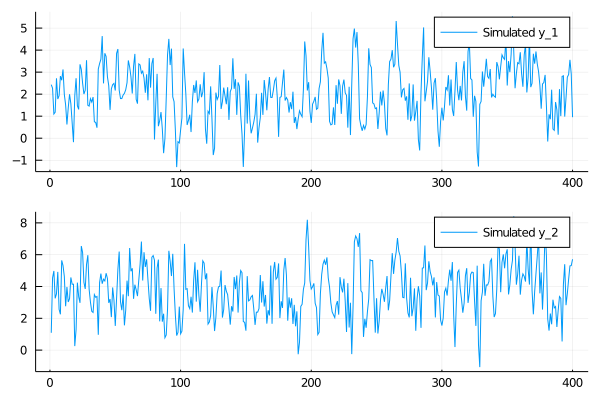

In [2]:
## Simulate data
p = 1;
n = 2;
k = n*p+1;
nk = n*k;
T = 400;

true_beta = [1 0.5 0; 1 1 0.2];
true_Sig = I(2);

true_betavec = reshape(transpose(true_beta),nk,1);
y = zeros(T,n);
y0 = zeros(1,n);
y[1,:] = transpose(kron(I(n),[1 y0])*true_betavec + (cholesky(true_Sig).L)*rand(Normal(0,1),n));
for t = 2:T
y[t,:] = transpose(kron(I(n),[1 y[t-1,:]'])*true_betavec + (cholesky(true_Sig).L)*rand(Normal(0,1),n));
end

x = collect(1:1:T);
data = y;
p1a = plot(x,data[:,1], label="Simulated y_1")
p1b = plot(x,data[:,2], label="Simulated y_2")
plot(p1a,p1b,layout = (2,1))

In [3]:
## Posterior analysis
# VAR inputs
p = 1;              # VAR order

# Create y
y0 = data[1:p,:];     # Initial conditions
y = data[p+1:end,:];  # Observations
(T,n) = size(y);
np = n*p;
nk = n*k;
Tn = T*n;
k = np+1;
longy = reshape(transpose(y),Tn,1);

# Create X
tempX = zeros(T,np);
for i in 1:p
    tempX[:,1+(i-1)*n:i*n] = data[p-i+1:end-i,:];
end
X = [ones(T) tempX]; # Txk matrix
bigX = zeros(Tn,nk); # Tnxnk matrix
for t in 1:T
    bigX[(t-1)*n+1:t*n,:] = kron(I(n),transpose(X[t,:]));
end


In [4]:
## Gibbs Sampler
# Controls
nburn = 5000;
ndraws = nburn + 10000;

# Prior for beta
pri_beta0 = zeros(nk);
tmp = 10*ones(nk); # precision for coeficients
tmp[1:np+1:nk] = ones(n);  # precision for intercepts
pri_invVbeta0 = sparse(collect(1:nk),collect(1:nk),tmp);

# Prior for Sigma
pri_nu = n+4;
pri_S = I(n)*(pri_nu-n-1); # sets E[Sigma] = I(n)

# Storage
nstore = ndraws - nburn;
s_beta = zeros(nstore,nk);
s_Sig = zeros(nstore,n^2);

# Initial conditions
MC_beta = Array(transpose(bigX)*bigX)\(transpose(bigX)*longy);
resid = reshape(longy-bigX*MC_beta,n,T);
MC_Sig = resid*transpose(resid)./T; # sum of squared residuals
MC_invSig = MC_Sig\I(n);

# Deterministic terms in posterior
post_nu = pri_nu + T;

# Gibbs Sampler
for loop in 1:ndraws
# Draw beta from multivariate Normal
    XinvSig = transpose(bigX)*kron(I(T),MC_invSig);
    post_invV = XinvSig*bigX + pri_invVbeta0; # precision matrix
    post_m = post_invV\(XinvSig*longy + pri_invVbeta0*pri_beta0);
    global MC_beta = post_m + transpose(cholesky(Hermitian(post_invV)).L)\rand(Normal(0,1),nk);

# Draw sig2 from InverseWishart
    err = reshape(longy-bigX*MC_beta,n,T);
    post_S = pri_S .+ err*transpose(err);
    global MC_Sig =  rand(InverseWishart(post_nu,post_S));
    global MC_invSig = MC_Sig\I(n);

# Store
    if loop > nburn
        count_loop = loop - nburn;
        s_beta[count_loop,:] = transpose(MC_beta);
        s_Sig[count_loop,:] = reshape(MC_Sig,1,n^2);
    end
end

Posterior mean: beta
[0.9415174612564627 0.5711508325905296 -0.015135917656740563 1.1650406269545346 0.8862766868814203 0.20286076964058244]
True beta
[1.0 0.5 0.0; 1.0 1.0 0.2]
Posterior mean: Sig
[1.006396016768066 -0.05687910366902995 -0.05687910366902995 1.0243730703379752]
True Sig
Bool[1 0; 0 1]


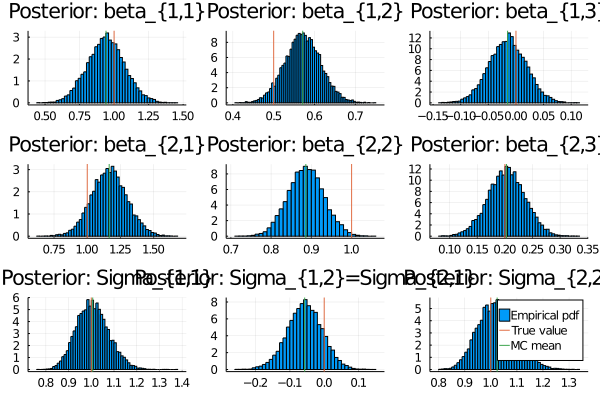

In [5]:
## Summarize results
# Compute posterior mean using Monte Carlo Integration
post_beta = mean(s_beta,dims=1);
post_Sig = mean(s_Sig,dims=1);

println("Posterior mean: beta")
println(post_beta)

println("True beta")
println(true_beta)

println("Posterior mean: Sig")
println(post_Sig)

println("True Sig")
println(true_Sig)

# Plot marginal posterior distributions for beta
x = collect(0:0.1:5);
histogram(x,s_beta[:,1], normalize=:pdf, title = "Posterior: beta_{1,1}", legend = false)
plot!([true_beta[1,1]], seriestype="vline", legend = false)
p2a = plot!([post_beta[1]], seriestype="vline", legend = false)

histogram(x,s_beta[:,2], normalize=:pdf, title = "Posterior: beta_{1,2}", legend = false)
plot!([true_beta[1,2]], seriestype="vline", legend = false)
p2b = plot!([post_beta[2]], seriestype="vline", legend = false)

histogram(x,s_beta[:,3], normalize=:pdf, title = "Posterior: beta_{1,3}", legend = false)
plot!([true_beta[1,3]], seriestype="vline", legend = false)
p2c = plot!([post_beta[3]], seriestype="vline", legend = false)

histogram(x,s_beta[:,4], normalize=:pdf, title = "Posterior: beta_{2,1}", legend = false)
plot!([true_beta[2,1]], seriestype="vline", legend = false)
p2d = plot!([post_beta[4]], seriestype="vline", legend = false)

histogram(x,s_beta[:,5], normalize=:pdf, title = "Posterior: beta_{2,2}", legend = false)
plot!([true_beta[2,2]], seriestype="vline", legend = false)
p2e = plot!([post_beta[5]], seriestype="vline", legend = false)

histogram(x,s_beta[:,6], normalize=:pdf, title = "Posterior: beta_{2,3}", legend = false)
plot!([true_beta[2,3]], seriestype="vline", legend = false)
p2f = plot!([post_beta[6]], seriestype="vline", legend = false)

histogram(x,s_Sig[:,1], normalize=:pdf, title = "Posterior: Sigma_{1,1}", legend = false)
plot!([true_Sig[1,1]], seriestype="vline", legend = false)
p2g = plot!([post_Sig[1]], seriestype="vline", legend = false)

histogram(x,s_Sig[:,2], normalize=:pdf, title = "Posterior: Sigma_{1,2}=Sigma_{2,1}", legend = false)
plot!([true_Sig[1,2]], seriestype="vline", legend = false)
p2h = plot!([post_Sig[2]], seriestype="vline", legend = false)

histogram(x,s_Sig[:,4], normalize=:pdf, title = "Posterior: Sigma_{2,2}", label="Empirical pdf")
plot!([true_Sig[2,2]], seriestype="vline", label="True value")
p2i = plot!([post_Sig[4]], seriestype="vline",  label="MC mean")

plot(p2a,p2b,p2c,p2d,p2e,p2f,p2g,p2h,p2i,layout = (3,3))


# Conclusion
The VAR) model is used to model relationships between multiple time series of interest, making it one of the most commonly used models in empirical macroeconomics. From a Bayesian perspective, estimating the VAR is the same as estimating the unknown parameters from a multivariate Normal distribution. If we are willing to assume prior independence, then the conjugate independent Normal and inverse-Wishart priors facilitate the use of a two block Gibbs sampler.

In the next lecture we will discuss how to estimate large Bayesian VARs, which have been a popular area of research over the past decade.

## Recommended reading
1. A great discussion about BVARs is provided in [Chapter 10](http://apps.eui.eu/Personal/Canova/Articles/ch10.pdf) of [Methods for Applied Macroeconomic Research by Fabio Canova](https://press.princeton.edu/books/hardcover/9780691115047/methods-for-applied-macroeconomic-research)
